#Spatio-Temporal Analysis and Prediction of Traffic Congestion in New Delhi
Palak Chauhan (2023UCD2119) - Anwita Das (2023UCD2127) - Ishika Mahawar (2023UCD2135)



In [85]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import re

Data Preprocessing

In [86]:
def parse_time_to_seconds(time_str):

    if not isinstance(time_str, str):
        return None

    # find all sequences of digits in the string
    numbers = re.findall(r'\d+', time_str)

    if len(numbers) == 2:
        # Case: "a min b s" -> numbers will be ['a', 'b']
        minutes = int(numbers[0])
        seconds = int(numbers[1])
        return minutes * 60 + seconds
    elif len(numbers) == 1:
        # Case: "a min" -> numbers will be ['a']
        minutes = int(numbers[0])
        return minutes * 60
    else:
        # Handles cases where the format is unexpected or empty
        return None

def parse_percentage(perc_str):
    """Converts 'A%' string to integer."""
    if isinstance(perc_str, str):
        return int(perc_str.replace('%', ''))
    return None

def parse_speed(speed_str):
    """Converts '<num> km/h' string to integer."""
    if isinstance(speed_str, str):
        return int(speed_str.replace(' km/h', ''))
    return None

def process_traffic_data(congestion_file, speed_file, time_file, area_name):
    """Loads, cleans, and merges traffic data for a specific area (city or urban)."""

    df_congestion = pd.read_csv(congestion_file)
    df_speed = pd.read_csv(speed_file)
    df_time = pd.read_csv(time_file)

    # Melt dataframes from wide to long format to make them tidy
    df_congestion = df_congestion.melt(id_vars='Time', var_name='DayOfWeek', value_name='Congestion')
    df_speed = df_speed.melt(id_vars='Time', var_name='DayOfWeek', value_name='Speed')
    df_time = df_time.melt(id_vars='Time', var_name='DayOfWeek', value_name='TravelTime')

    # Apply the cleaning functions to each respective column
    df_congestion['Congestion'] = df_congestion['Congestion'].apply(parse_percentage)
    df_speed['Speed'] = df_speed['Speed'].apply(parse_speed)
    df_time['TravelTime'] = df_time['TravelTime'].apply(parse_time_to_seconds)

    # Merge the individual dataframes into a single comprehensive one
    df_merged = pd.merge(df_congestion, df_speed, on=['Time', 'DayOfWeek'])
    df_merged = pd.merge(df_merged, df_time, on=['Time', 'DayOfWeek'])

    # Add a column to identify the area (City or Urban)
    df_merged['Area'] = area_name

    return df_merged

In [87]:
df_city = process_traffic_data(
    '2024_week_day_congestion_city.csv',
    '2024_week_day_speed_city.csv',
    '2024_week_day_time_city.csv',
    'City')

df_urban = process_traffic_data(
    '2024_week_day_congestion_urban.csv',
    '2024_week_day_speed_urban.csv',
    '2024_week_day_time_urban.csv',
    'Urban')

df_combined = pd.concat([df_city, df_urban])

time_order = [
    "12:00 AM", "02:00 AM", "04:00 AM", "06:00 AM", "08:00 AM", "10:00 AM",
    "12:00 PM", "02:00 PM", "04:00 PM", "06:00 PM", "08:00 PM", "10:00 PM" ]
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

df_combined['Time'] = pd.Categorical(df_combined['Time'], categories=time_order, ordered=True)
df_combined['DayOfWeek'] = pd.Categorical(df_combined['DayOfWeek'], categories=day_order, ordered=True)

print("DataFrame head:")
print(df_combined.head())
print("\nDataFrame Info:")
df_combined.info()

DataFrame head:
       Time DayOfWeek  Congestion  Speed  TravelTime  Area
0  12:00 AM    Sunday           0     35        1031  City
1  02:00 AM    Sunday           0     37         973  City
2  04:00 AM    Sunday           0     39         930  City
3  06:00 AM    Sunday           0     36         909  City
4  08:00 AM    Sunday           0     34         979  City

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 168 entries, 0 to 83
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Time        168 non-null    category
 1   DayOfWeek   168 non-null    category
 2   Congestion  168 non-null    int64   
 3   Speed       168 non-null    int64   
 4   TravelTime  168 non-null    int64   
 5   Area        168 non-null    object  
dtypes: category(2), int64(3), object(1)
memory usage: 7.6+ KB


In [88]:
import json
import pandas as pd
import numpy as np
import glob
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder

geojson_files = glob.glob("new_delhi__*.geojson")

if not geojson_files:
    print("Error: No GeoJSON files found. Please ensure they are uploaded.")
else:
    print(f"Found {len(geojson_files)} GeoJSON files. Processing...")

    time_set_map = {}
    with open(geojson_files[0], 'r') as f:
        first_data = json.load(f)

    # Find the metadata feature that contains 'timeSets'
    for feature in first_data.get('features', []):
        if feature.get('geometry') is None and 'timeSets' in feature.get('properties', {}):
            for ts in feature['properties']['timeSets']:
                # Format is like "0:00-1:00". We take the first part "0" as the hour.
                hour = int(ts['name'].split('-')[0].split(':')[0])
                time_set_map[ts['@id']] = hour
            break

Found 20 GeoJSON files. Processing...


Exploratory Data Analysis

In [89]:
print("\n1. Overall Traffic Summary (City)")

with open('new_delhi_2024_city_traffic.json', 'r') as f:
    city_traffic_summary = json.load(f)

print(f"Average Travel Time per 10km: {city_traffic_summary['average_travel_time_per_10_km']}")
print(f"Average Speed: {city_traffic_summary['average_speed_km_h']} km/h")
print(f"Worst Day to Travel in 2024: {city_traffic_summary['worst_day_to_travel_2024']['date']} with an average travel time of {city_traffic_summary['worst_day_to_travel_2024']['avg_travel_time_per_10_km']}.")



1. Overall Traffic Summary (City)
Average Travel Time per 10km: 23 min 24 s
Average Speed: 25.6 km/h
Worst Day to Travel in 2024: October 25, Friday with an average travel time of 27 min 51 s.


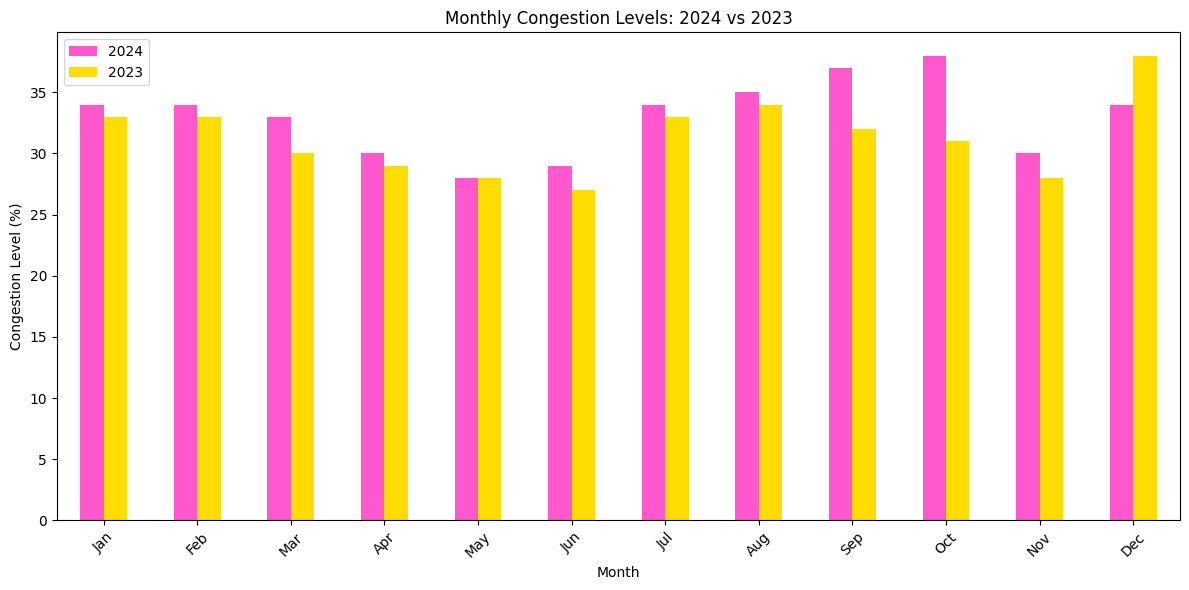

In [90]:
df_monthly = pd.DataFrame(city_traffic_summary['monthly_congestion_level'])
df_monthly.plot(x='month', y=['2024', '2023'], kind='bar', figsize=(12, 6), rot=45, color=['#FF57CD', '#FFDD03'])
plt.title('Monthly Congestion Levels: 2024 vs 2023')
plt.ylabel('Congestion Level (%)')
plt.xlabel('Month')
plt.tight_layout()
plt.savefig('monthly_congestion.png')
plt.show()

In [91]:
def plot_heatmap(df, area, metric):
    plt.figure(figsize=(10, 8))
    pivot_table = df[df['Area'] == area].pivot_table(
        values=metric,
        index='Time',
        columns='DayOfWeek',
        aggfunc='mean'
    )
    sns.heatmap(pivot_table, cmap="plasma", annot=True, fmt=".0f", linewidths=.5)
    plt.title(f'{metric} Heatmap for {area} Area')
    plt.xlabel('Day of Week')
    plt.ylabel('Time of Day')
    plt.tight_layout()
    plt.savefig(f'{area.lower()}_{metric.lower()}_heatmap.png')
    plt.show()

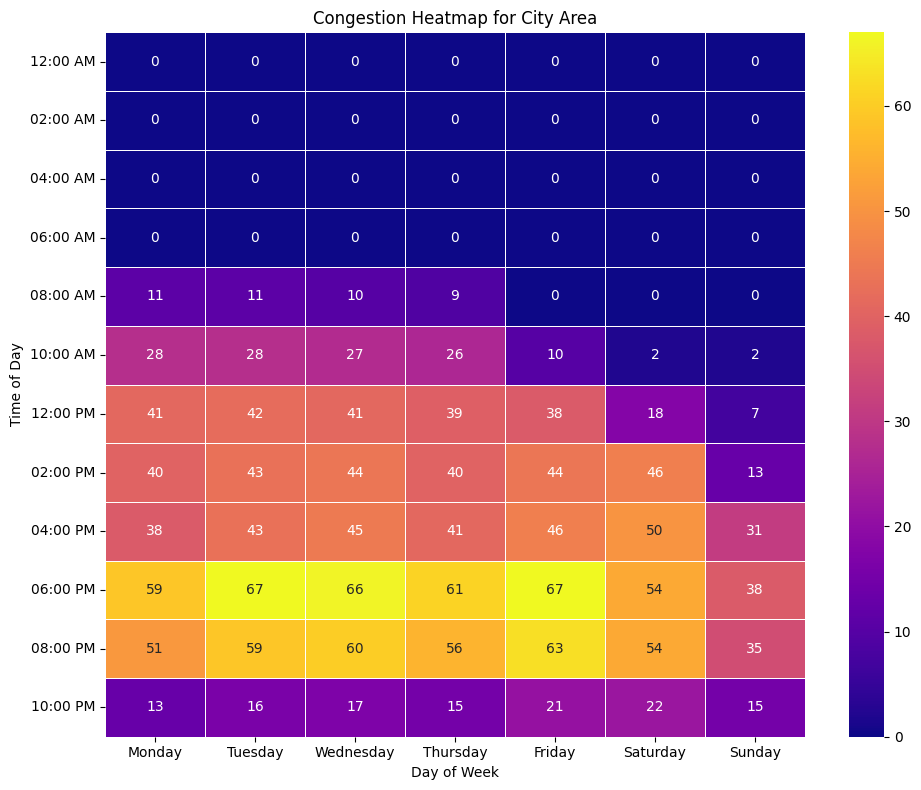

In [92]:
plot_heatmap(df_combined, 'City', 'Congestion')

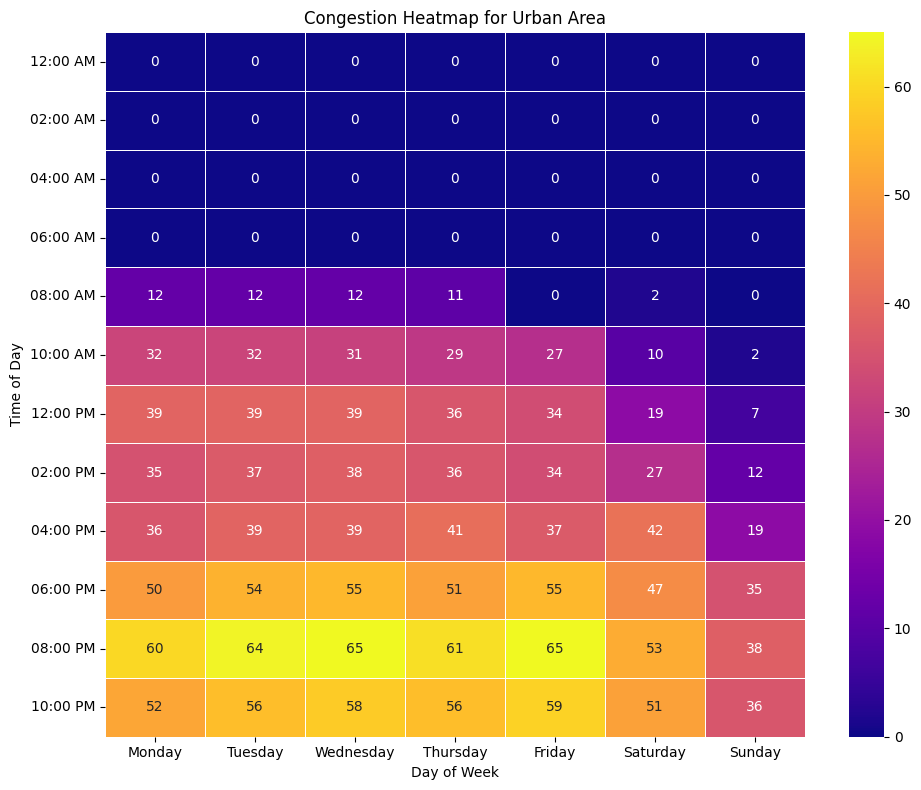

In [93]:
plot_heatmap(df_combined, 'Urban', 'Congestion')

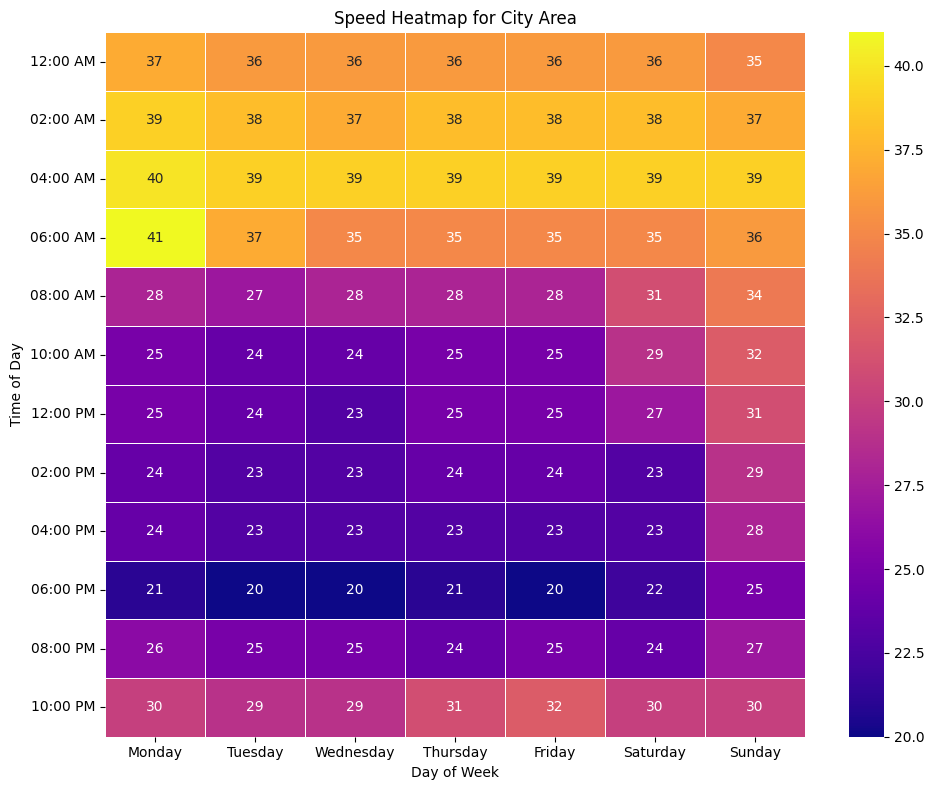

In [94]:
plot_heatmap(df_combined, 'City', 'Speed')

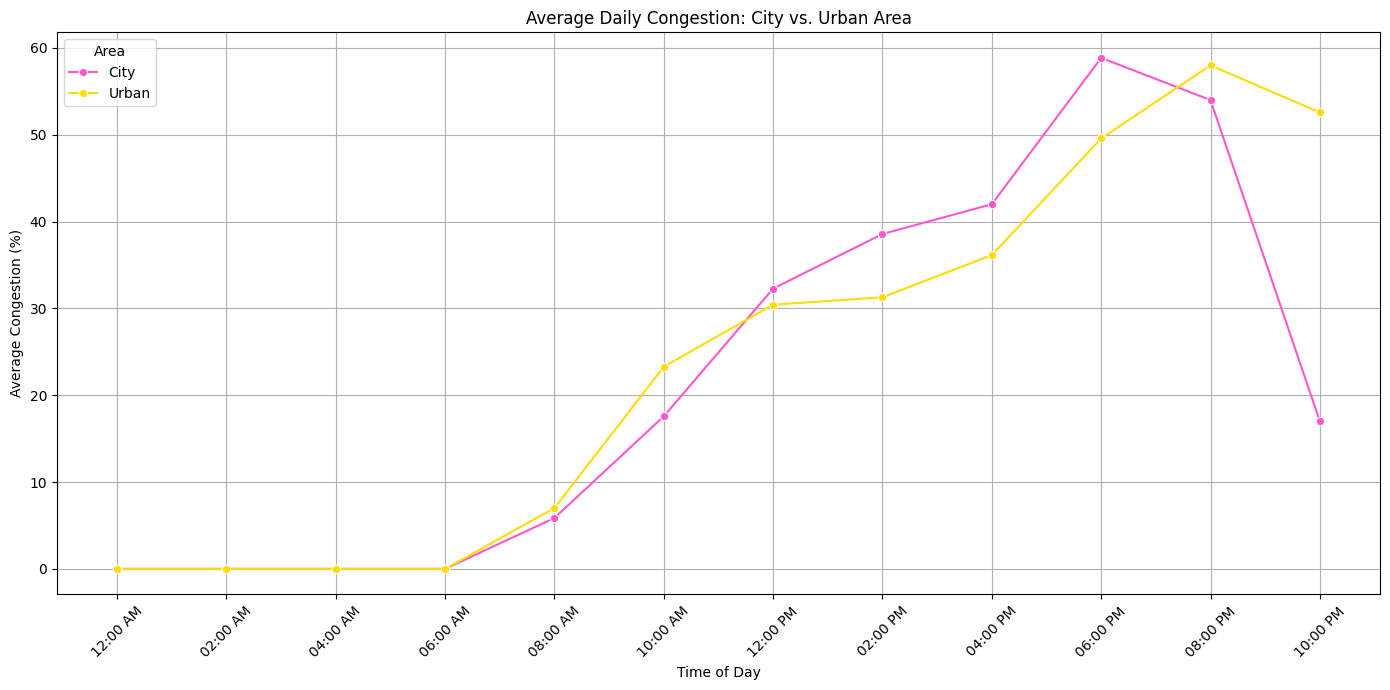

In [95]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_combined, x='Time', y='Congestion', hue='Area', marker='o', errorbar=None, palette=['#FF57CD', '#FFDD03'])
plt.title('Average Daily Congestion: City vs. Urban Area')
plt.xlabel('Time of Day')
plt.ylabel('Average Congestion (%)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Area')
plt.tight_layout()
plt.savefig('daily_congestion_comparison.png')
plt.show()

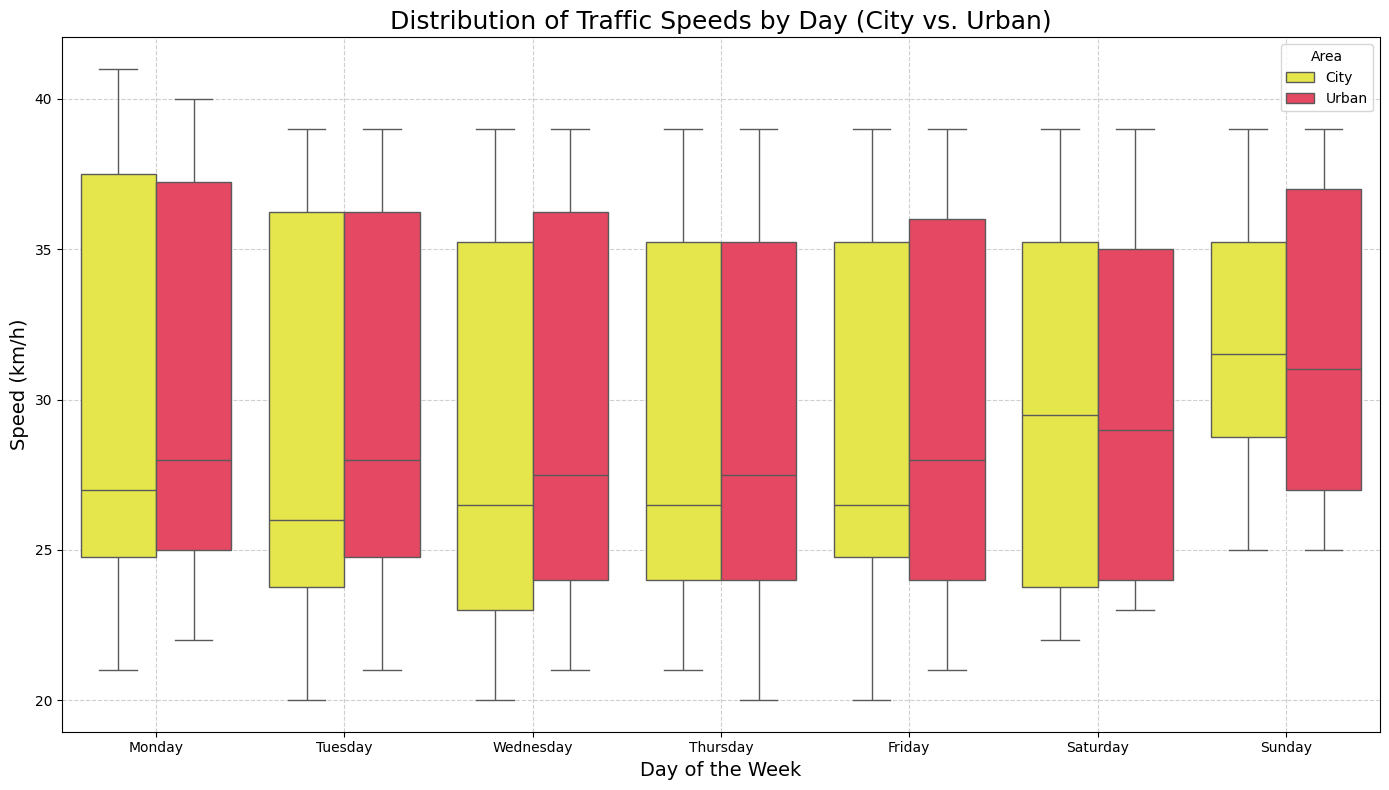

In [96]:
plt.figure(figsize=(14, 8))
sns.boxplot(x='DayOfWeek', y='Speed', hue='Area', data=df_combined, palette=['#FEFE33','#FF2E51'])

plt.title('Distribution of Traffic Speeds by Day (City vs. Urban)', fontsize=18)
plt.xlabel('Day of the Week', fontsize=14)
plt.ylabel('Speed (km/h)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Area')
plt.tight_layout()
plt.savefig('speed_distribution_boxplot.png')
plt.show()

In [97]:
with open('2024_city_rush_hour.json', 'r') as f:
    city_rush_hour = json.load(f)
with open('2024_urban_rush_hour.json', 'r') as f:
    urban_rush_hour = json.load(f)

print("\n--- Rush Hour Comparison ---")
print("\nCity Area:")
print(f"  Morning Rush Hour: {city_rush_hour['morning_rush_hour']['congestion_level_percent']}% congestion, Avg Speed: {city_rush_hour['morning_rush_hour']['average_speed_kmh']} km/h")
print(f"  Evening Rush Hour: {city_rush_hour['evening_rush_hour']['congestion_level_percent']}% congestion, Avg Speed: {city_rush_hour['evening_rush_hour']['average_speed_kmh']} km/h")
print(f"  Annual Extra Time in Rush Hour: {city_rush_hour['annual_extra_rush_hour_time']['total']}")

print("\nUrban Area:")
print(f"  Morning Rush Hour: {urban_rush_hour['morning_rush_hour']['congestion_level_percent']}% congestion, Avg Speed: {urban_rush_hour['morning_rush_hour']['average_speed_kmh']} km/h")
print(f"  Evening Rush Hour: {urban_rush_hour['evening_rush_hour']['congestion_level_percent']}% congestion, Avg Speed: {urban_rush_hour['evening_rush_hour']['average_speed_kmh']} km/h")
print(f"  Annual Extra Time in Rush Hour: {urban_rush_hour['annual_extra_rush_hour_time']['total']}")


--- Rush Hour Comparison ---

City Area:
  Morning Rush Hour: 43% congestion, Avg Speed: 23.6 km/h
  Evening Rush Hour: 69% congestion, Avg Speed: 19.9 km/h
  Annual Extra Time in Rush Hour: 76 hours (3 days, 4 hours)

Urban Area:
  Morning Rush Hour: 38% congestion, Avg Speed: 24.0 km/h
  Evening Rush Hour: 63% congestion, Avg Speed: 20.1 km/h
  Annual Extra Time in Rush Hour: 70 hours (2 days, 22 hours)


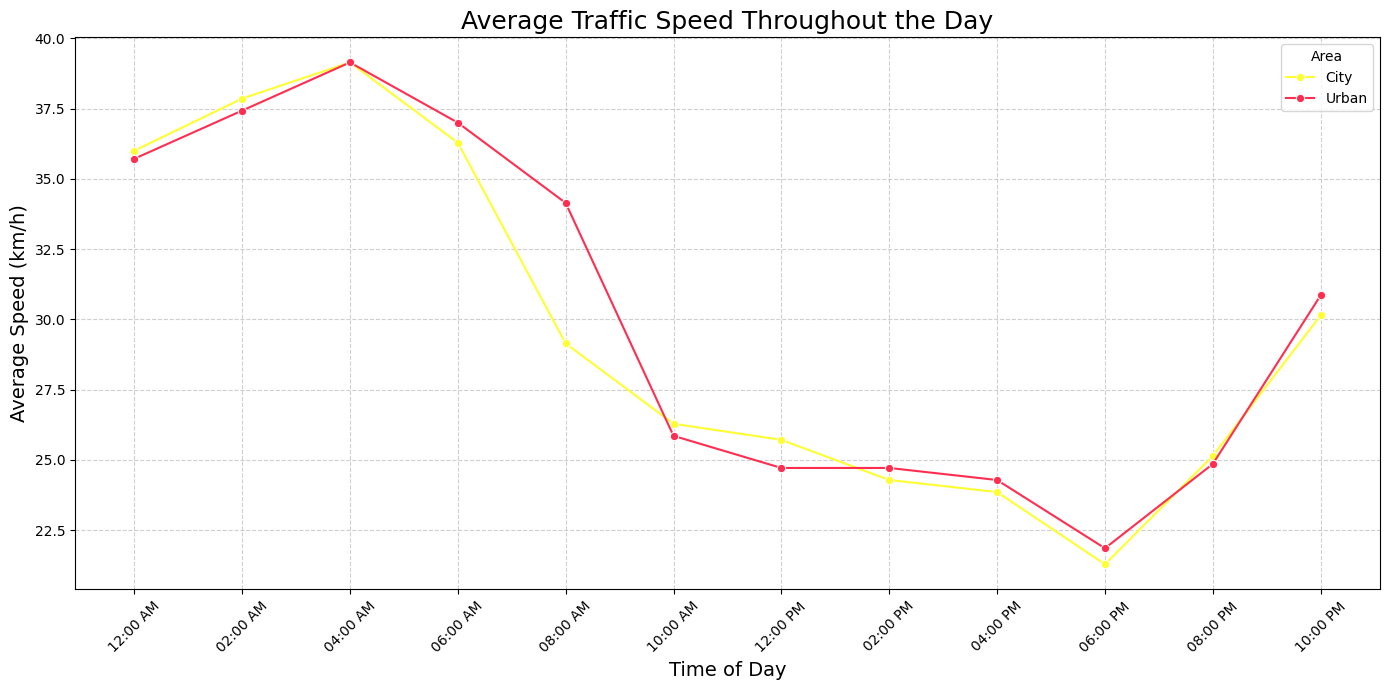

In [98]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_combined, x='Time', y='Speed', hue='Area', marker='o', errorbar=None, palette=['#FEFE33','#FF2E51'])
plt.title('Average Traffic Speed Throughout the Day', fontsize=18)
plt.xlabel('Time of Day', fontsize=14)
plt.ylabel('Average Speed (km/h)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Area')
plt.tight_layout()
plt.show()

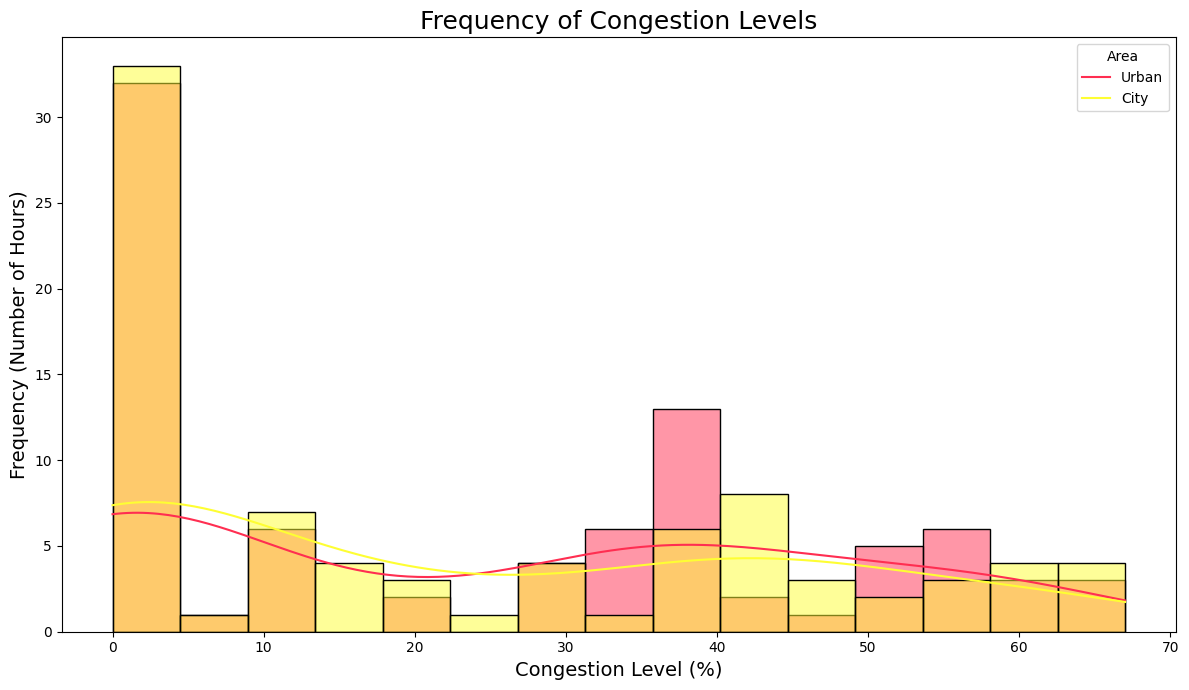

In [99]:

plt.figure(figsize=(12, 7))
sns.histplot(data=df_combined, x='Congestion', hue='Area', multiple='layer', bins=15, kde=True, palette=['#FEFE33','#FF2E51'])
plt.title('Frequency of Congestion Levels', fontsize=18)
plt.xlabel('Congestion Level (%)', fontsize=14)
plt.ylabel('Frequency (Number of Hours)', fontsize=14)
plt.legend(title='Area', labels=['Urban', 'City'])
plt.tight_layout()
plt.show()

Loading new_delhi__2024-08-24_to_2024-08-24_.geojson...
Data Loaded Successfully! Shape: (24939, 16)

Column Info:
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 24939 entries, 0 to 24938
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   jobName             1 non-null      object             
 1   creationTime        1 non-null      datetime64[ms, UTC]
 2   segmentId           24938 non-null  float64            
 3   newSegmentId        24938 non-null  object             
 4   speedLimit          24938 non-null  float64            
 5   frc                 24938 non-null  float64            
 6   streetName          22709 non-null  object             
 7   distance            24938 non-null  float64            
 8   segmentProbeCounts  24938 non-null  object             
 9   userPreference      1 non-null      object             
 10  dateRanges          1 non-null 

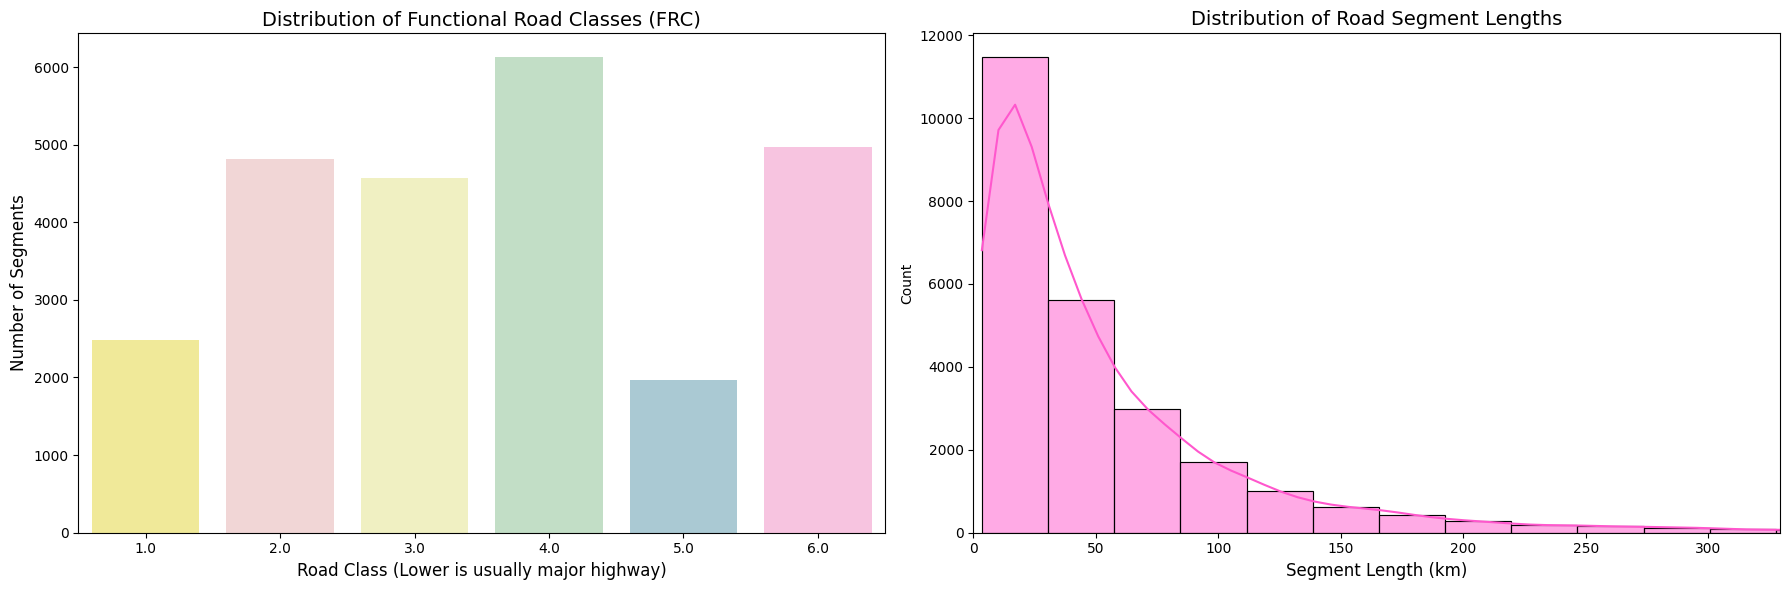

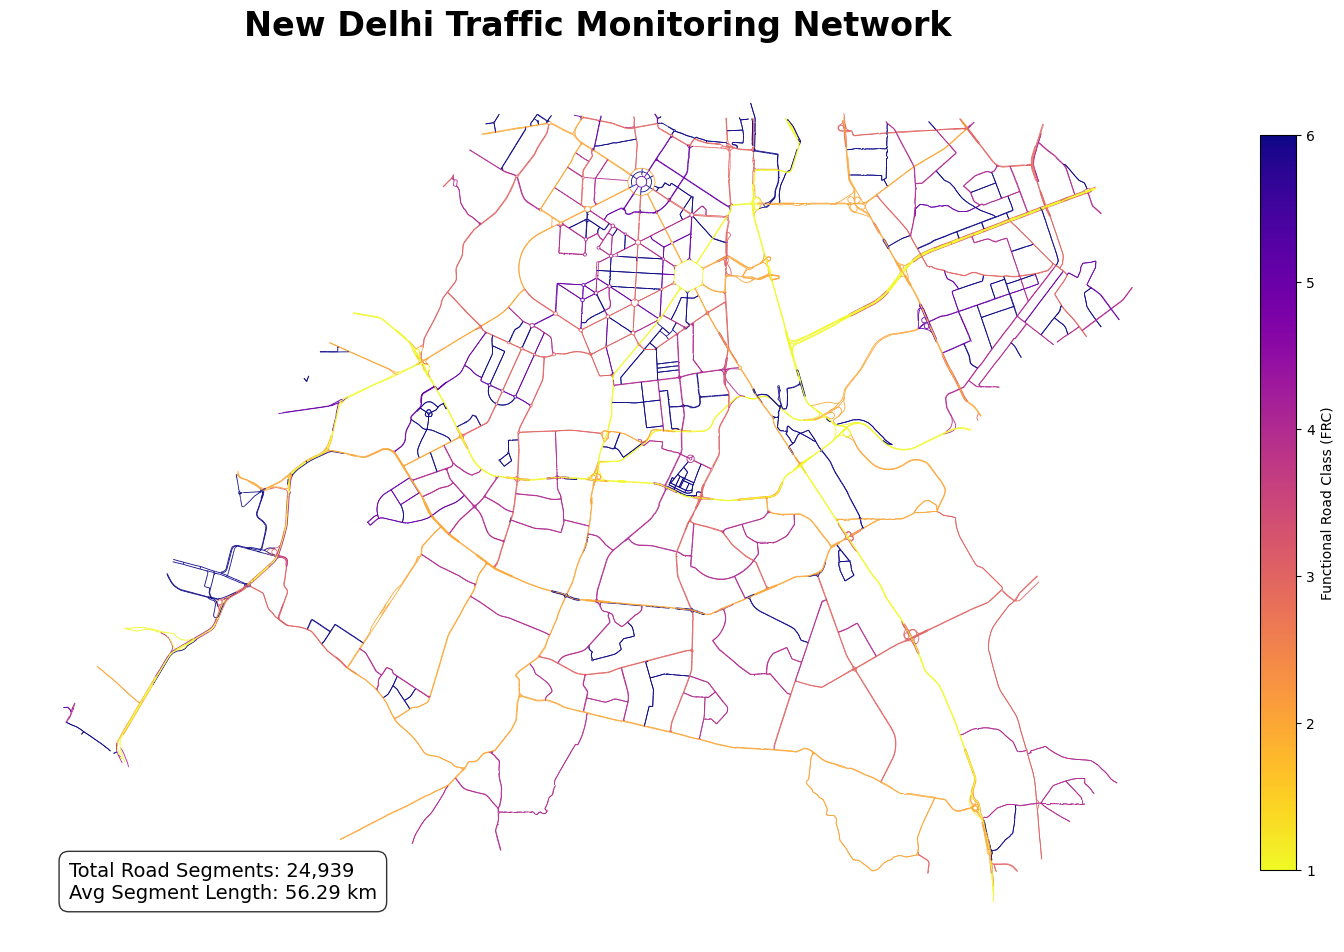

In [100]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

file_path = "new_delhi__2024-08-24_to_2024-08-24_.geojson"
print(f"Loading {file_path}...")
try:
    gdf = gpd.read_file(file_path)
    print(f"Data Loaded Successfully! Shape: {gdf.shape}")
    print("\nColumn Info:")
    print(gdf.info())
except Exception as e:
    print(f"Error loading file: {e}")
    gdf = None

if gdf is not None:
    fig_eda, axes = plt.subplots(1, 2, figsize=(18, 6))

    # Distribution of Road Types (FRC)
    sns.countplot(data=gdf, x='frc', palette=['#FFF58A','#F5D2D2','#F8F7BA','#BDE3C3','#A3CCDA','#FFBBE1'], ax=axes[0])
    axes[0].set_title("Distribution of Functional Road Classes (FRC)", fontsize=14)
    axes[0].set_xlabel("Road Class (Lower is usually major highway)", fontsize=12)
    axes[0].set_ylabel("Number of Segments", fontsize=12)

    # Road Length Distribution
    sns.histplot(data=gdf, x='distance', bins=50, color='#FF57CD', kde=True, ax=axes[1])
    axes[1].set_title("Distribution of Road Segment Lengths", fontsize=14)
    axes[1].set_xlabel("Segment Length (km)", fontsize=12)
    axes[1].set_xlim(0, gdf['distance'].quantile(0.99)) # Trim extreme outliers for better view

    plt.tight_layout()
    plt.show()

    fig_map, ax_map = plt.subplots(figsize=(15, 15))

    gdf.plot(column='frc',
             cmap='plasma_r',
             linewidth=0.6,
             ax=ax_map,
             legend=True,
             legend_kwds={'label': "Functional Road Class (FRC)", 'shrink': 0.5})

    ax_map.set_title("New Delhi Traffic Monitoring Network", fontsize=24, fontweight='bold', pad=20)
    ax_map.set_facecolor('#f0f0f0')
    ax_map.set_axis_off()

    stats = f"Total Road Segments: {len(gdf):,}\nAvg Segment Length: {gdf['distance'].mean():.2f} km"
    plt.text(0.05, 0.05, stats, transform=ax_map.transAxes, fontsize=14,
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='black', boxstyle='round,pad=0.5'))

    plt.tight_layout()
    plt.show()

Feature Engineering

In [101]:
import json
import pandas as pd
import numpy as np
import glob
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder

geojson_files = glob.glob("new_delhi__*.geojson")

if not geojson_files:
    print("Error: No GeoJSON files found. Please ensure they are uploaded.")
else:

    daily_traffic = []
    for file_name in geojson_files:
        try:
            # Extract date from filename: new_delhi__YYYY-MM-DD_to_...
            date_str = os.path.basename(file_name).split('__')[1].split('_')[0]
            date_dt = pd.to_datetime(date_str)
            day_name = date_dt.day_name()

            with open(file_name, 'r') as f:
                data = json.load(f)

            # Sum up probes for the whole city for this day, hour by hour
            day_counts = {}
            for feature in data.get('features', []):
                props = feature.get('properties', {})
                if feature.get('geometry') is not None and 'segmentProbeCounts' in props:
                    for entry in props['segmentProbeCounts']:
                        ts_id = entry['timeSet']
                        day_counts[ts_id] = day_counts.get(ts_id, 0) + entry['probeCount']

            # Add to our master list
            for ts_id, count in day_counts.items():
                if ts_id in time_set_map:
                    daily_traffic.append({
                        'Day': day_name,
                        'Hour_Numeric': time_set_map[ts_id],
                        'Probe_Count': count
                    })
        except Exception as e:
            print(f"Error processing {file_name}: {e}")

    df_geo = pd.DataFrame(daily_traffic)
    df_geo_avg = df_geo.groupby(['Day', 'Hour_Numeric'])['Probe_Count'].mean().reset_index()

    print(df_geo_avg.head())

      Day  Hour_Numeric   Probe_Count
0  Friday             0  1.621683e+06
1  Friday             1  1.078715e+06
2  Friday             2  7.547230e+05
3  Friday             3  6.994230e+05
4  Friday             4  8.654873e+05


In [102]:
def load_and_melt(c_file, s_file, t_file, area):
    # Read files INSIDE the function to avoid scope issues
    df_c = pd.read_csv(c_file)
    df_s = pd.read_csv(s_file)
    df_t = pd.read_csv(t_file)

    df_c_melt = df_c.melt(id_vars=['Time'], var_name='Day', value_name='Congestion')
    df_s_melt = df_s.melt(id_vars=['Time'], var_name='Day', value_name='Speed')

    # Merge on Time AND Day
    df_merged = pd.merge(df_c_melt, df_s_melt, on=['Time', 'Day'])

    df_merged['Area'] = area
    return df_merged

# Load data
df_city = load_and_melt('2024_week_day_congestion_city.csv', '2024_week_day_speed_city.csv', '2024_week_day_time_city.csv', 'City')
df_urban = load_and_melt('2024_week_day_congestion_urban.csv', '2024_week_day_speed_urban.csv', '2024_week_day_time_urban.csv', 'Urban')
df_combined = pd.concat([df_city, df_urban], ignore_index=True)

# Clean
df_combined['Congestion'] = df_combined['Congestion'].str.replace('%', '').astype(int)
df_combined['Hour_Numeric'] = pd.to_datetime(df_combined['Time'], format='%I:%M %p').dt.hour
df_combined['Day'] = df_combined['Day'].str.strip() # Ensure no whitespace issues in 'Day'

# --- MERGE GEOJSON DATA ---
# Merge on 'Day' and 'Hour_Numeric'. 'Day' must exist in both.
df_final = pd.merge(df_combined, df_geo_avg, on=['Day', 'Hour_Numeric'], how='left')
df_final['Probe_Count'] = df_final['Probe_Count'].fillna(df_final['Probe_Count'].mean())

print("Final dataset ready:", df_final.shape)
print("Columns:", df_final.columns.tolist())


Final dataset ready: (168, 7)
Columns: ['Time', 'Day', 'Congestion', 'Speed', 'Area', 'Hour_Numeric', 'Probe_Count']


In [103]:
from sklearn.preprocessing import LabelEncoder

# Convert 'Time' to a numerical 24-hour format
def time_to_numeric(t_str):
    # Assuming format like "08:00 AM"
    dt = pd.to_datetime(t_str, format='%I:%M %p')
    return dt.hour + dt.minute / 60.0

df_combined['Hour_Numeric'] = df_combined['Time'].apply(time_to_numeric)

# Create Peak Hour Flags based on your rush hour data
# Morning rush: roughly 8 AM - 10 AM
df_combined['Is_Morning_Rush'] = df_combined['Hour_Numeric'].apply(lambda x: 1 if 8 <= x <= 10 else 0)
# Evening rush: roughly 5 PM (17:00) - 9 PM (21:00)
df_combined['Is_Evening_Rush'] = df_combined['Hour_Numeric'].apply(lambda x: 1 if 17 <= x <= 21 else 0)

# Encode Categorical Variables
# Encode 'Area' (City=0, Urban=1)
le_area = LabelEncoder()
df_combined['Area_Code'] = le_area.fit_transform(df_combined['Area'])

day_map = {'Monday':0, 'Tuesday':1, 'Wednesday':2, 'Thursday':3, 'Friday':4, 'Saturday':5, 'Sunday':6}
df_combined['Day_Numeric'] = df_combined['Day'].map(day_map)

print(df_combined[['Time', 'Day', 'Area', 'Hour_Numeric', 'Is_Evening_Rush', 'Congestion']].head())


df_final['Area_Code'] = le_area.fit_transform(df_final['Area'])
day_map = {'Monday':0, 'Tuesday':1, 'Wednesday':2, 'Thursday':3, 'Friday':4, 'Saturday':5, 'Sunday':6}
df_final['Day_Numeric'] = df_final['Day'].map(day_map)
df_final['Is_Rush'] = df_final['Hour_Numeric'].apply(lambda x: 1 if (8<=x<=10) or (17<=x<=21) else 0)

       Time     Day  Area  Hour_Numeric  Is_Evening_Rush  Congestion
0  12:00 AM  Sunday  City           0.0                0           0
1  02:00 AM  Sunday  City           2.0                0           0
2  04:00 AM  Sunday  City           4.0                0           0
3  06:00 AM  Sunday  City           6.0                0           0
4  08:00 AM  Sunday  City           8.0                0           0


Machine Learning models


Regression Results:
                Model        MAE  R2 Score
2      Random Forest   2.317647  0.974516
1      Decision Tree   3.764706  0.900262
0  Linear Regression   7.950206  0.824387
3                SVR  11.897222  0.570153

Classification Results:
                  Model  Accuracy  F1 Score (Weighted)
1        Decision Tree  0.941176             0.913866
2        Random Forest  0.941176             0.913866
3                  SVM  0.941176             0.913866
0  Logistic Regression  0.882353             0.857143


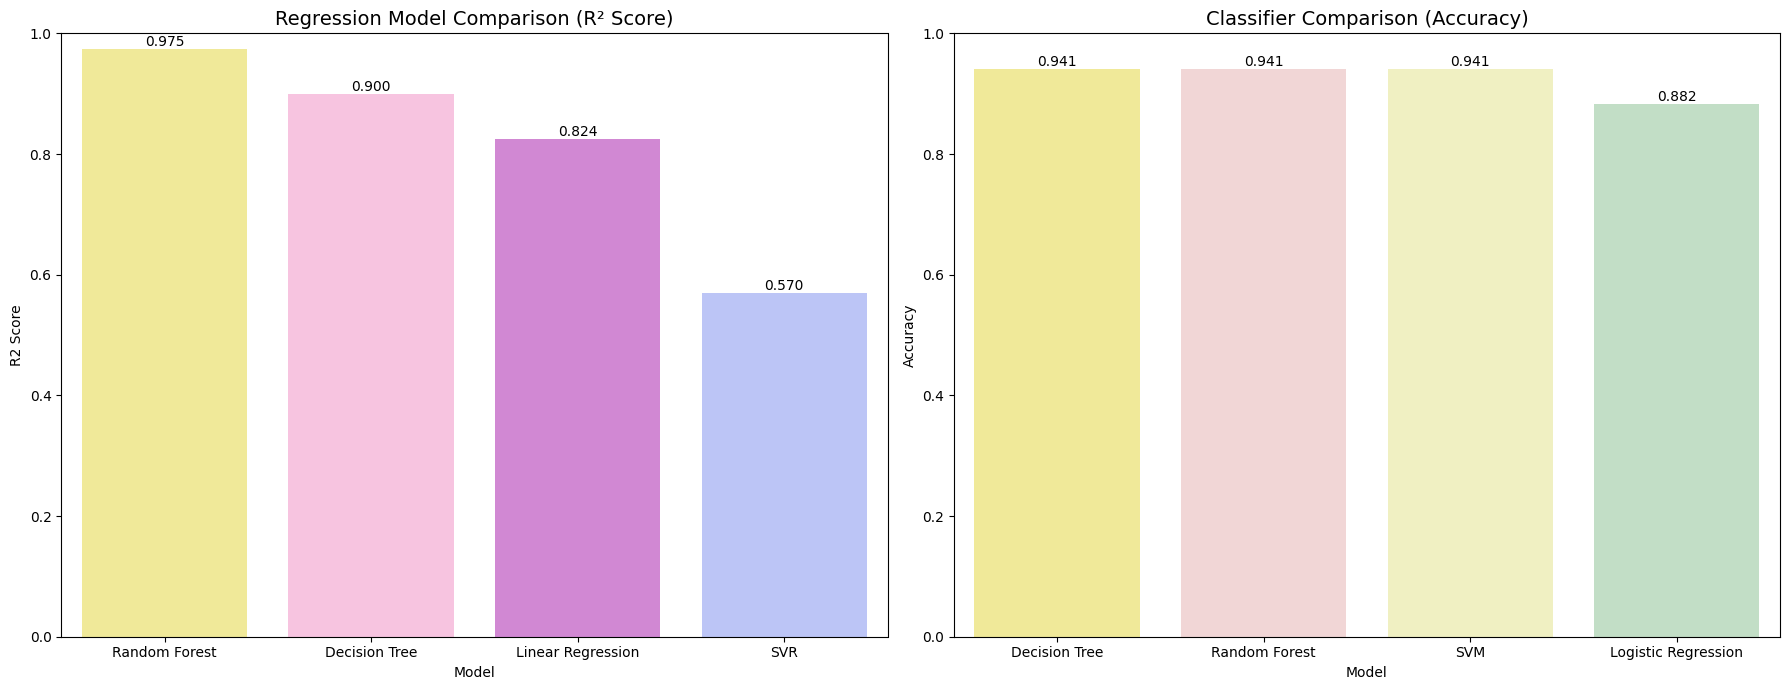

In [104]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score, f1_score, classification_report
# Regressors
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC



# REGRESSSION MODELS
reg_features = ['Hour_Numeric', 'Day_Numeric', 'Area_Code', 'Is_Rush', 'Probe_Count']
X_reg = df[reg_features]
y_reg = df['Congestion']


scaler = StandardScaler()
X_reg_scaled = scaler.fit_transform(X_reg)
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reg_scaled, y_reg, test_size=0.2, random_state=42)

reg_models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "SVR": SVR(kernel='rbf')
}

reg_results = []
for name, model in reg_models.items():
    model.fit(X_train_r, y_train_r)
    y_pred = model.predict(X_test_r)
    reg_results.append({
        "Model": name,
        "MAE": mean_absolute_error(y_test_r, y_pred),
        "R2 Score": r2_score(y_test_r, y_pred)
    })
df_reg_results = pd.DataFrame(reg_results).sort_values("R2 Score", ascending=False)
print("\nRegression Results:\n", df_reg_results)

# CLASSIFICATION MODELS
X_cls = df[reg_features] # Same features
y_cls = df['Congestion_Class'] # Categorical target

X_cls_scaled = scaler.fit_transform(X_cls)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_cls_scaled, y_cls, test_size=0.2, random_state=42)

cls_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='rbf')
}

cls_results = []
for name, model in cls_models.items():
    model.fit(X_train_c, y_train_c)
    y_pred = model.predict(X_test_c)
    cls_results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test_c, y_pred),
        "F1 Score (Weighted)": f1_score(y_test_c, y_pred, average='weighted')
    })
df_cls_results = pd.DataFrame(cls_results).sort_values("Accuracy", ascending=False)
print("\nClassification Results:\n", df_cls_results)

# Visualization

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot Regression R2
sns.barplot(data=df_reg_results, x='Model', y='R2 Score', palette=['#FFF58A','#FFBBE1','#DD7BDF','#B3BFFF'], ax=axes[0])
axes[0].set_title("Regression Model Comparison (R² Score)", fontsize=14)
axes[0].set_ylim(0, 1.0)
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%.3f')

# Plot Classification Accuracy
sns.barplot(data=df_cls_results, x='Model', y='Accuracy', palette=['#FFF58A','#F5D2D2','#F8F7BA','#BDE3C3'], ax=axes[1])
axes[1].set_title("Classifier Comparison (Accuracy)", fontsize=14)
axes[1].set_ylim(0, 1.0)
for container in axes[1].containers:
    axes[1].bar_label(container, fmt='%.3f')

plt.tight_layout()
plt.show()

In [105]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# We will try to predict 'Congestion' based on time, day, and area.

features = ['Hour_Numeric', 'Day_Numeric', 'Area_Code', 'Is_Rush', 'Probe_Count']
target = 'Congestion'

X_train, X_test, y_train, y_test = train_test_split(
    df_final[features], df_final[target], test_size=0.2, random_state=42
)

#Random Forest model
rf_enhanced = RandomForestRegressor(n_estimators=100, random_state=42)
rf_enhanced.fit(X_train, y_train)

print("Training Complete.")

Training Complete.


Regression Model Evaluation

In [106]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = rf_enhanced.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n--- Model Evaluation Metrics ---")
print(f"Mean Absolute Error (MAE): {mae:.2f}%")
# Interpretation: On average, our prediction is off by this many percentage points.
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.4f}")
# Interpretation: How well the model fits the data (1.0 is perfect fit).


--- Model Evaluation Metrics ---
Mean Absolute Error (MAE): 2.14%
Root Mean Squared Error (RMSE): 3.42
R² Score: 0.9777


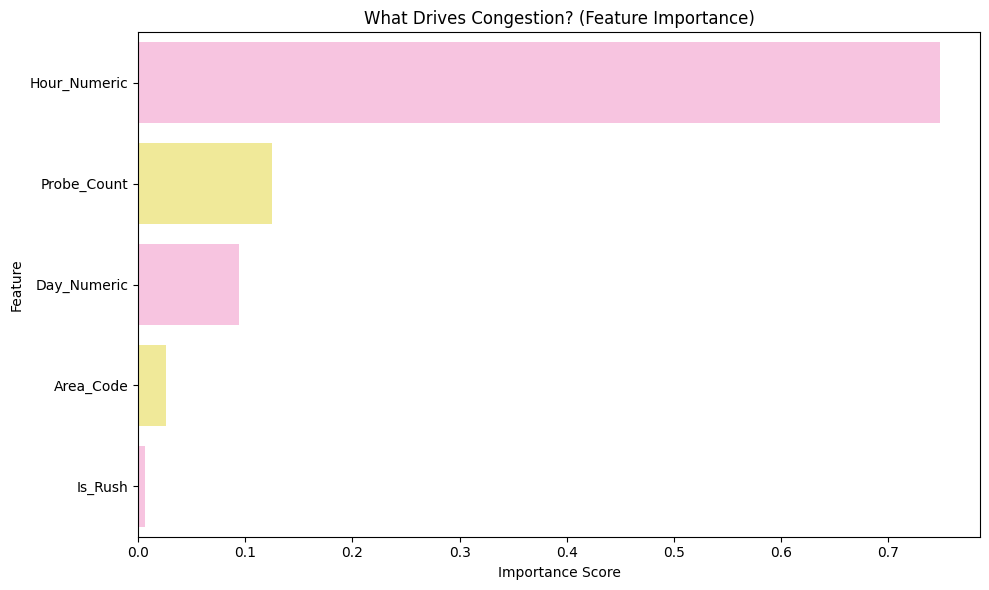

        feature  importance
0  Hour_Numeric    0.748145
4   Probe_Count    0.124863
1   Day_Numeric    0.094589
2     Area_Code    0.025643
3       Is_Rush    0.006760


In [107]:
import matplotlib.pyplot as plt
import seaborn as sns

feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature', palette=['#FFBBE1', '#FFF58A'])
plt.title("What Drives Congestion? (Feature Importance)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

print(feature_importance)